<a href="https://colab.research.google.com/github/AUT-Student/BigData-HW2/blob/main/BigData_HW2_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><b>In the name of God</b></center>

<b>Course</b>: ‌Big Data
<br>
<b>Description:</b> HomeWork 1 | Question 3
<br>
<b>Developer</b>: Alireza Mazochi (400131075)

# PySpark Setting

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [3]:
spark

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from pyspark.sql.types import FloatType, ArrayType, IntegerType
from pyspark.sql.functions import udf
import pyspark.sql.functions as f
from pyspark.sql import Window

# Dataset

In [2]:
!gdown 1PdXgb4w0gtsocKHmeGQ_zPfb3VbW9YhL
!unzip /content/Bigdata_hw2_datasets.zip

Downloading...
From: https://drive.google.com/uc?id=1PdXgb4w0gtsocKHmeGQ_zPfb3VbW9YhL
To: /content/Bigdata_hw2_datasets.zip
100% 6.28M/6.28M [00:00<00:00, 45.7MB/s]
Archive:  /content/Bigdata_hw2_datasets.zip
   creating: Bigdata_hw2_datasets/
   creating: Bigdata_hw2_datasets/q1/
  inflating: Bigdata_hw2_datasets/q1/stream_data_dgim.txt  
   creating: Bigdata_hw2_datasets/q2/
  inflating: Bigdata_hw2_datasets/q2/games.csv  
  inflating: Bigdata_hw2_datasets/q2/ratings.csv  
   creating: Bigdata_hw2_datasets/q3/
  inflating: Bigdata_hw2_datasets/q3/c1.txt  
  inflating: Bigdata_hw2_datasets/q3/c2.txt  
  inflating: Bigdata_hw2_datasets/q3/data.txt  


In [3]:
dataset_pandas = pd.read_csv("/content/Bigdata_hw2_datasets/q3/data.txt", header=None, names=["data"])
dataset_pandas["data"] = dataset_pandas["data"].apply(lambda x:x.split(" "))
dataset_pandas["data"] = dataset_pandas["data"].apply(lambda item: [float(x) for x in item])
dataset_pandas["data-id"] = range(len(dataset_pandas))

c1_pandas = pd.read_csv("/content/Bigdata_hw2_datasets/q3/c1.txt", header=None, names=["center"])
c1_pandas["center"] = c1_pandas["center"].apply(lambda x:x.split(" "))
c1_pandas["center"] = c1_pandas["center"].apply(lambda item: [float(x) for x in item])
c1_pandas["center-id"] = range(len(c1_pandas))

c2_pandas = pd.read_csv("/content/Bigdata_hw2_datasets/q3/c2.txt", header=None, names=["center"])
c2_pandas["center"] = c2_pandas["center"].apply(lambda x:x.split(" "))
c2_pandas["center"] = c2_pandas["center"].apply(lambda item: [float(x) for x in item])
c2_pandas["center-id"] = range(len(c2_pandas))

In [4]:
NUMBER_FEATURES = len(dataset_pandas["data"].values[0])

# KMeans

In [10]:
class SparkKMeans():
  def __init__(self, dataset, center, description, distance_metric_name):
    self.dataset_spark = spark.createDataFrame(dataset)
    self.center_spark = spark.createDataFrame(center)
    self.description = description

    if distance_metric_name == "Euclidean":
      self.distance_metric = self.euclidean_distance
    elif distance_metric_name == "Manhatan":
      self.distance_metric = self.manhatan_distance
    else:
      raise Exception("Invalid distance_metric_name!")

  def run(self, number_epochs):
    self.number_epochs = number_epochs
    self.costs = []
    for step in range(number_epochs):
      data_center_spark = self.dataset_spark.join(self.center_spark)\
                              .withColumn('distance', self.distance_metric(self.dataset_spark.data, self.center_spark.center))

      data_center_spark = data_center_spark.withColumn("min-distance", f.min("distance")\
                                           .over(Window.partitionBy("data-id")))\
                                           .where(f.col("min-distance") == f.col("distance"))\
                                           .drop(*["min-distance", "center"])

      step_cost = data_center_spark.select("distance")\
                                   .groupBy().sum().collect()[0][0]
      
      self.costs.append(step_cost)
      print(f"Step = {step}, Cost = {step_cost}")

      data_center_mapping = data_center_spark.drop(*["data", "distance"])\
                                             .toDF("data-id", "center-id")\
                                             .toPandas()
      
      data_center_spark = data_center_spark.groupBy("center-id")\
                                           .agg(f.collect_list("data")\
                                           .alias("data-list"))

      array_mean_udf = udf(self.array_mean, ArrayType(FloatType()))

      self.center_spark = data_center_spark.select("center-id", array_mean_udf("data-list")\
                                           .alias("center"))

    return data_center_mapping

  def report(self):
    print(f"Change cost percent in ten steps {int((self.costs[0] - self.costs[10]) / self.costs[0] * 100)}%\n") 

    plt.scatter(range(1, self.number_epochs+1), self.costs)
    plt.plot(range(1, self.number_epochs+1), self.costs)
    plt.xlabel("Step")
    plt.ylabel("Cost")
    plt.title(f"Change Cost in KMeans\n{self.description}")
    plt.show()

  @staticmethod
  def euclidean_distance(a, b):
    distance = 0
    for i in range(NUMBER_FEATURES):
      distance += (a[i] - b[i]) ** 2
    return distance ** 0.5

  @staticmethod
  def manhatan_distance(a, b):
    distance = 0
    for i in range(NUMBER_FEATURES):
      distance += f.abs(a[i] - b[i])
    return distance

  @staticmethod
  def array_mean(x):
    number_data = len([i for i in zip(*x)][0])
    sum_array = [sum(i) for i in zip(*x)]
    return [item/number_data for item in sum_array]

# Results

Distance Metric = Euclidean | Center Name = C1
Step = 0, Cost = 395749.8468388532
Step = 1, Cost = 318949.51101113483
Step = 2, Cost = 316897.8071501825
Step = 3, Cost = 327978.22519918176
Step = 4, Cost = 333528.0769713639
Step = 5, Cost = 334334.41537335224
Step = 6, Cost = 334093.90368501254
Step = 7, Cost = 333273.4312510706
Step = 8, Cost = 331554.1755801971
Step = 9, Cost = 329840.47699853603
Step = 10, Cost = 328722.7106742206
Step = 11, Cost = 328750.6934242609
Step = 12, Cost = 329348.7148805231
Step = 13, Cost = 329348.8991447655
Step = 14, Cost = 329282.30882074387
Step = 15, Cost = 329642.62883340573
Step = 16, Cost = 329593.37367925036
Step = 17, Cost = 329459.8591616328
Step = 18, Cost = 329719.50750799815
Step = 19, Cost = 330176.9366961528
Change cost percent in ten steps 16%



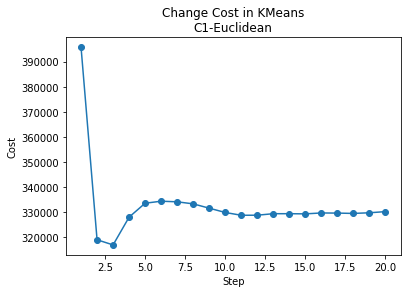

Distance Metric = Euclidean | Center Name = C2
Step = 0, Cost = 1150355.5436059786
Step = 1, Cost = 825718.3815378408
Step = 2, Cost = 708799.3820943746
Step = 3, Cost = 657164.9968611912
Step = 4, Cost = 625836.6047303933
Step = 5, Cost = 607124.6611016592
Step = 6, Cost = 589221.9843275077
Step = 7, Cost = 568010.6121654253
Step = 8, Cost = 539364.637782208
Step = 9, Cost = 515826.6172109743
Step = 10, Cost = 498616.298471274
Step = 11, Cost = 484873.4854135511
Step = 12, Cost = 474576.71495498193
Step = 13, Cost = 466189.7460151896
Step = 14, Cost = 459349.7074162843
Step = 15, Cost = 453778.7245210844
Step = 16, Cost = 449818.2257010622
Step = 17, Cost = 446966.3756914019
Step = 18, Cost = 444163.5018917574
Step = 19, Cost = 441696.6980722874
Change cost percent in ten steps 56%



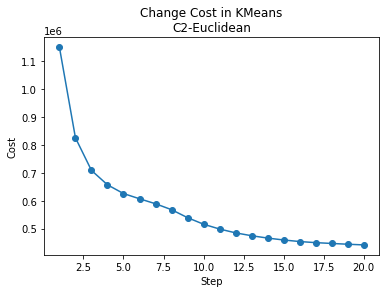

Distance Metric = Manhatan | Center Name = C1
Step = 0, Cost = 565475.4720000032
Step = 1, Cost = 466514.2971280042
Step = 2, Cost = 470857.75163717516
Step = 3, Cost = 483869.30878529814
Step = 4, Cost = 489200.84700234374
Step = 5, Cost = 487576.0291287648
Step = 6, Cost = 483583.2481417699
Step = 7, Cost = 475324.8079596467
Step = 8, Cost = 474856.0566063218
Step = 9, Cost = 457207.7554022045
Step = 10, Cost = 447505.25173996756
Step = 11, Cost = 450946.12209732604
Step = 12, Cost = 451237.9370883775
Step = 13, Cost = 451958.97678462823
Step = 14, Cost = 451570.36446897686
Step = 15, Cost = 452739.01060344203
Step = 16, Cost = 453082.7303367916
Step = 17, Cost = 450583.67023330537
Step = 18, Cost = 450368.7457612367
Step = 19, Cost = 449011.3633032016
Change cost percent in ten steps 20%



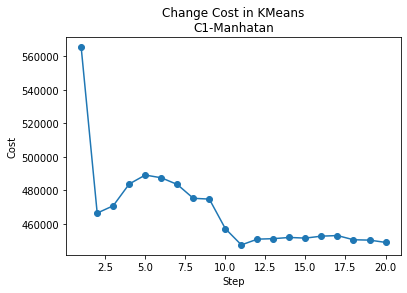

Distance Metric = Manhatan | Center Name = C2
Step = 0, Cost = 1433739.3099999938
Step = 1, Cost = 1084488.7693964501
Step = 2, Cost = 973431.7202677557
Step = 3, Cost = 895934.5987381018
Step = 4, Cost = 865128.3216957817
Step = 5, Cost = 845846.65922853
Step = 6, Cost = 827219.5871540306
Step = 7, Cost = 803590.3411259102
Step = 8, Cost = 756039.519582125
Step = 9, Cost = 717332.9004420241
Step = 10, Cost = 694587.9250391687
Step = 11, Cost = 684444.498730303
Step = 12, Cost = 674574.7499253174
Step = 13, Cost = 667409.4706312704
Step = 14, Cost = 663556.6249497061
Step = 15, Cost = 660162.7754313725
Step = 16, Cost = 656041.3237065368
Step = 17, Cost = 653036.7599125181
Step = 18, Cost = 651112.4272994011
Step = 19, Cost = 649689.017906071
Change cost percent in ten steps 51%



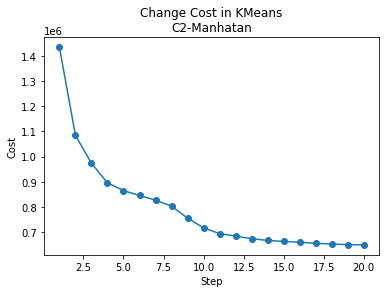

In [ ]:
for distance_metric_name in ["Euclidean", "Manhatan"]:
  for center, center_name in [(c1_pandas, "C1"), (c2_pandas, "C2")]:
    print(f"Distance Metric = {distance_metric_name} | Center Name = {center_name}")

    kmeans = SparkKMeans(dataset=dataset_pandas, center=center, description=f"{center_name}-{distance_metric_name}", distance_metric_name=distance_metric_name)

    kmeans_output = kmeans.run(number_epochs=20)

    kmeans.report()    

# Lab

Downloading...
From: https://drive.google.com/uc?id=1PdXgb4w0gtsocKHmeGQ_zPfb3VbW9YhL
To: /content/Bigdata_hw2_datasets.zip
100% 6.28M/6.28M [00:00<00:00, 295MB/s]
Archive:  /content/Bigdata_hw2_datasets.zip
replace Bigdata_hw2_datasets/q1/stream_data_dgim.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Bigdata_hw2_datasets/q1/stream_data_dgim.txt  
  inflating: Bigdata_hw2_datasets/q2/games.csv  
  inflating: Bigdata_hw2_datasets/q2/ratings.csv  
  inflating: Bigdata_hw2_datasets/q3/c1.txt  
  inflating: Bigdata_hw2_datasets/q3/c2.txt  
  inflating: Bigdata_hw2_datasets/q3/data.txt  
step = 0
Distance = 395749.8468388532
step = 1
Distance = 318949.5125678038
step = 2
Distance = 316897.80884241144
step = 3
Distance = 327978.2208163152
step = 4
Distance = 333528.07760380296


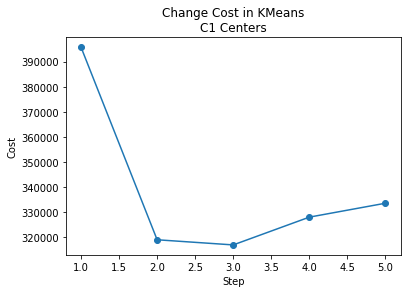

In [3]:
# Libraries
from copy import deepcopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!gdown 1PdXgb4w0gtsocKHmeGQ_zPfb3VbW9YhL
!unzip /content/Bigdata_hw2_datasets.zip

# Dataset
dataset_pandas = pd.read_csv("/content/Bigdata_hw2_datasets/q3/data.txt", header=None, names=["data"])
dataset_pandas["data"] = dataset_pandas["data"].apply(lambda x:x.split(" "))
dataset_pandas["data"] = dataset_pandas["data"].apply(lambda item: np.array([float(x) for x in item]))
dataset_pandas["data-id"] = range(len(dataset_pandas))

# Initial Centers
c1_pandas = pd.read_csv("/content/Bigdata_hw2_datasets/q3/c1.txt", header=None, names=["center"])
c1_pandas["center"] = c1_pandas["center"].apply(lambda x:x.split(" "))
c1_pandas["center"] = c1_pandas["center"].apply(lambda item: np.array([float(x) for x in item]))
c1_pandas["center-id"] = range(len(c1_pandas))

class KMeans():
  def __init__(self, dataset, center, description):
    self.description = description
    self.dataset_tmp = deepcopy(dataset)
    self.center_tmp = deepcopy(center)

  def run(self, number_epochs):
    self.number_epochs = number_epochs
    self.costs = []
    for step in range(number_epochs):
      print("=====================")
      print(f"step = {step}")

      self.dataset_tmp["center-id"] = np.nan
      self.dataset_tmp["distance"] = np.nan

      # Find center for each data
      for i, dataset_row in self.dataset_tmp.iterrows():
        data = dataset_row["data"]
        data_id = dataset_row["data-id"]

        best_center_id = None
        best_distance = np.inf
        for _, center_row in self.center_tmp.iterrows():
          center = center_row["center"]
          center_id = center_row["center-id"]

          distance = np.linalg.norm(data-center)

          if distance < best_distance:
            best_distance = distance
            best_center_id = center_id

        self.dataset_tmp.at[i, "center-id"] = best_center_id
        self.dataset_tmp.at[i, "distance"] = best_distance

      # Sum of distances
      print("Distance =", sum([x**2 for x in self.dataset_tmp["distance"].values]))
      self.costs.append(sum([x**2 for x in self.dataset_tmp["distance"].values]))

      # Update Center with its asigned data
      for i in range(len(self.center_tmp)):
        self.center_tmp.at[i, "center"] = np.average(self.dataset_tmp[self.dataset_tmp["center-id"] == i]["data"].values)

    return None

  # Plot costs
  def report(self):
    plt.scatter(range(1, self.number_epochs+1), self.costs)
    plt.plot(range(1, self.number_epochs+1), self.costs)
    plt.xlabel("Step")
    plt.ylabel("Cost")
    plt.title(f"Change Cost in KMeans\n{self.description}")
    plt.show()

# Run Algorithm
kmeans = KMeans(dataset=dataset_pandas, center=c1_pandas, description=f"C1 Centers")
kmeans_output = kmeans.run(number_epochs=5)
kmeans.report() 

In [10]:
dataset_tiny = pd.DataFrame({"data-id": range(12), "data":[
                                                            [0.0, 0.0],
                                                            [1.0, 0.0],
                                                            [0.0, 1.0],
                                                            [1.0, 1.0],
                                                            [5.0, 5.0],
                                                            [5.0, 4.0],
                                                            [4.0, 5.0],
                                                            [4.0, 4.0],
                                                            [10.0, 11.0],
                                                            [11.0, 11.0],
                                                            [11.0, 10.0],
                                                            [10.0, 10.0]]})

In [55]:
center_tiny = pd.DataFrame({"center-id": range(3), "center": [
                                                              [5.0, 7.0],
                                                              [5.0, 5.0],
                                                              [2.0, 10.0]
]})

Distance Metric = Euclidean | Center Name = C1
step = 0
Pandas Distance = 55.101766714302144
    data-id          data  center-id  distance
0         0    [0.0, 0.0]        1.0  7.071068
1         1    [1.0, 0.0]        1.0  6.403124
2         2    [0.0, 1.0]        1.0  6.403124
3         3    [1.0, 1.0]        1.0  5.656854
4         4    [5.0, 5.0]        1.0  0.000000
5         5    [5.0, 4.0]        1.0  1.000000
6         6    [4.0, 5.0]        1.0  1.000000
7         7    [4.0, 4.0]        1.0  1.414214
8         8  [10.0, 11.0]        0.0  6.403124
9         9  [11.0, 11.0]        0.0  7.211103
10       10  [11.0, 10.0]        0.0  6.708204
11       11  [10.0, 10.0]        0.0  5.830952
   center-id        center
0          0  [10.5, 10.5]
1          1    [2.5, 2.5]
2          2           NaN
step = 1
Pandas Distance = 25.804039413421545
    data-id          data  center-id  distance
0         0    [0.0, 0.0]        1.0  3.535534
1         1    [1.0, 0.0]        1.0  2.915476
2

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:191: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:191: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:191: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/c

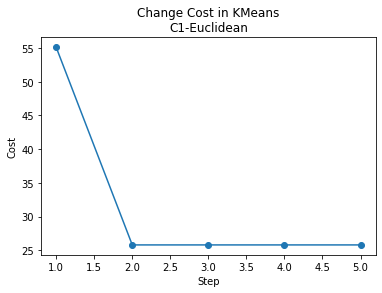

In [56]:
distance_metric_name = "Euclidean"
# distance_metric_name = "Manhatan"

center, center_name = (c1_pandas, "C1")

print(f"Distance Metric = {distance_metric_name} | Center Name = {center_name}")

kmeans = SparkKMeans(dataset=dataset_tiny, center=center_tiny, description=f"{center_name}-{distance_metric_name}", distance_metric_name=distance_metric_name)

kmeans_output = kmeans.run(number_epochs=5)

kmeans.report()    

Distance Metric = Euclidean | Center Name = C1
Pandas Distance = 395749.8468388532
Step = 0, Cost = 395749.8468388532


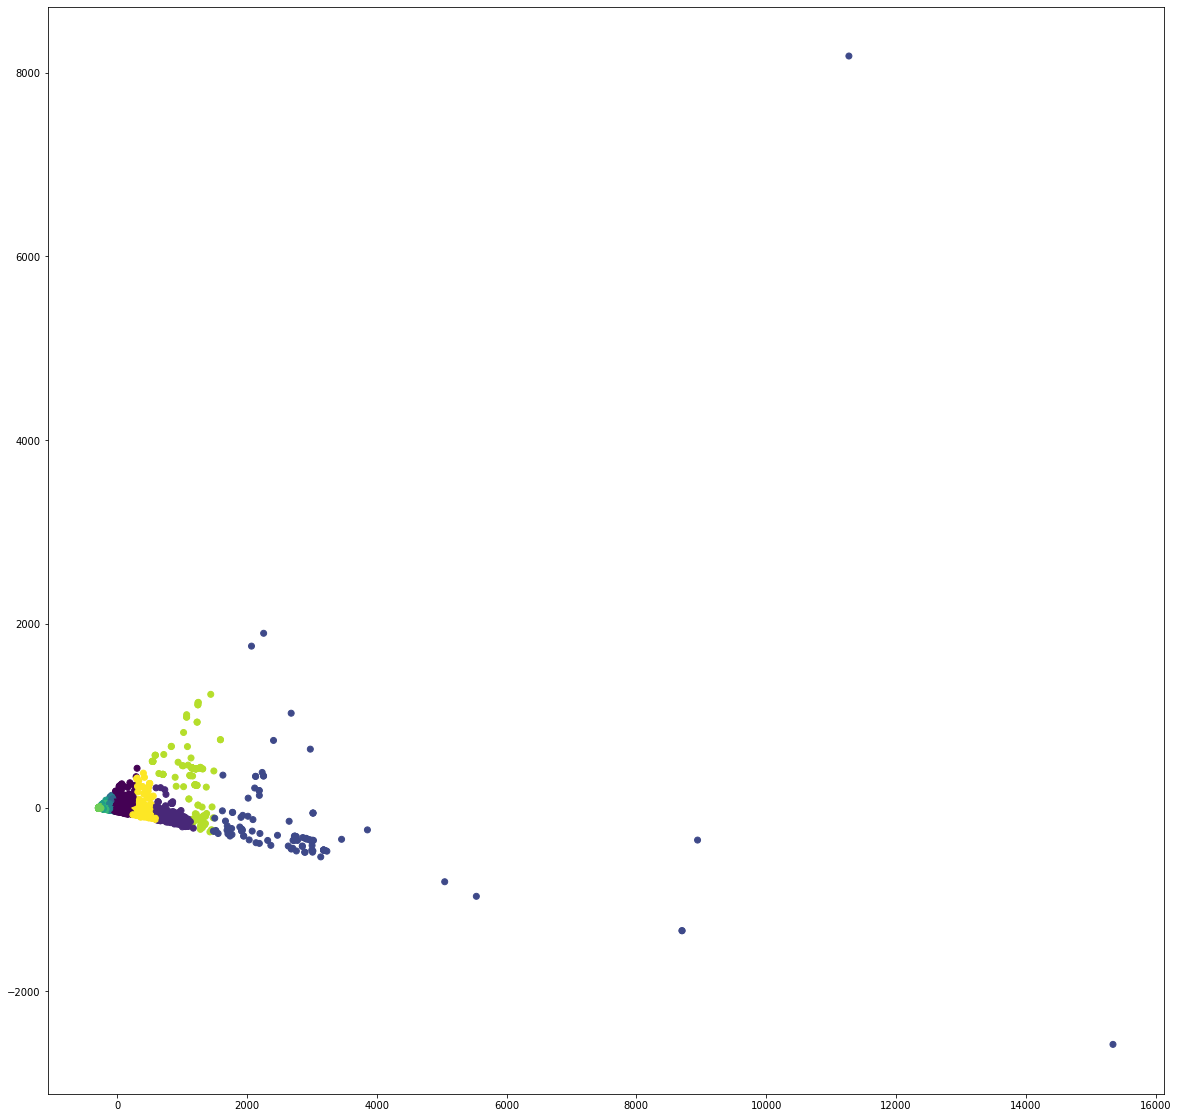

Pandas Distance = 318949.5125678038
Step = 1, Cost = 318949.51101113483


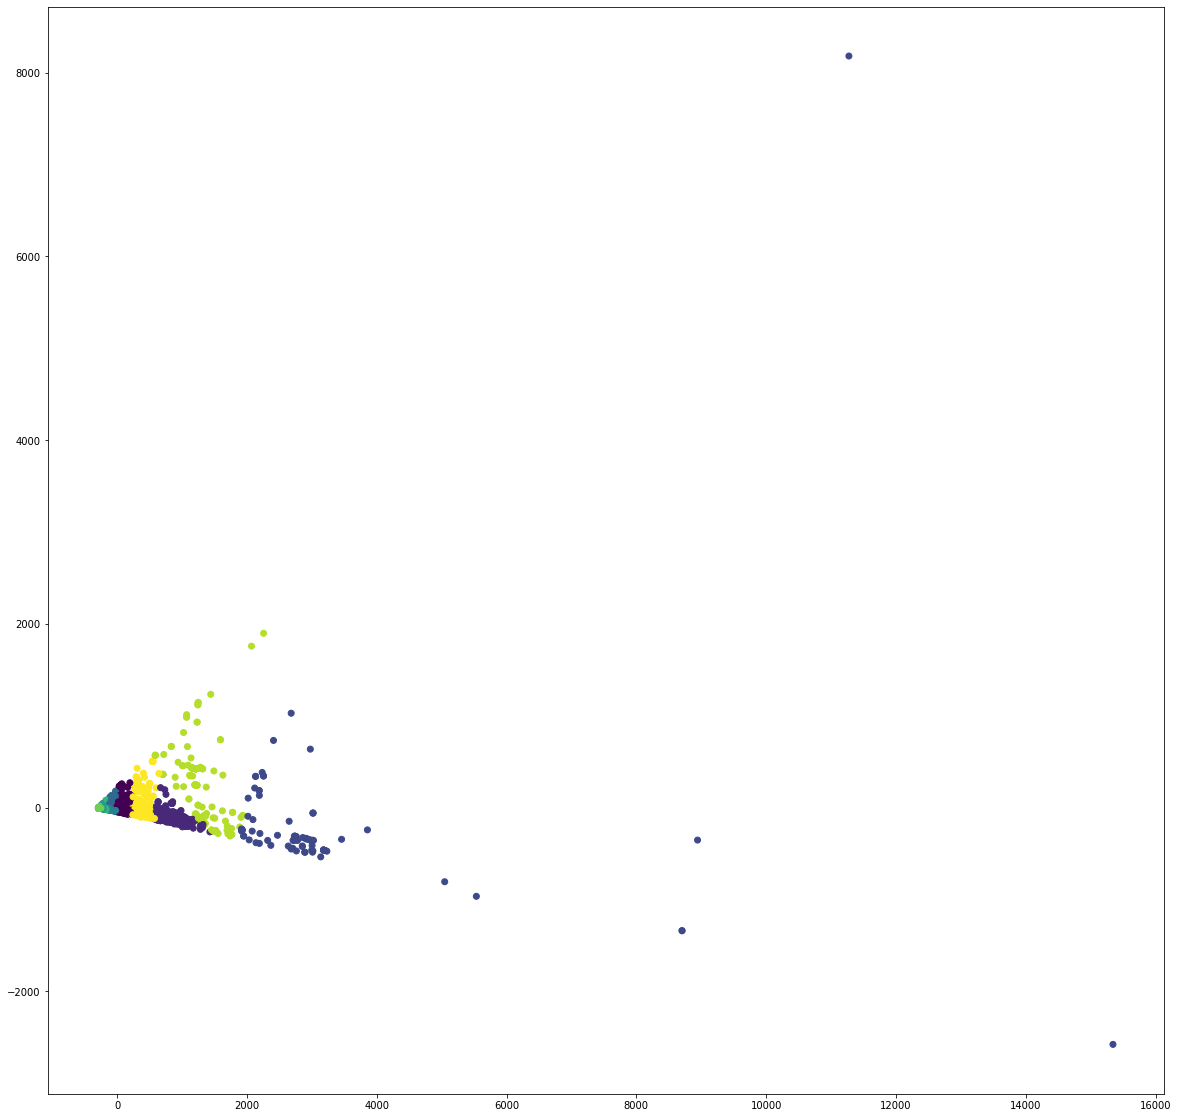

Pandas Distance = 316897.80884241144
Step = 2, Cost = 316897.8071501825


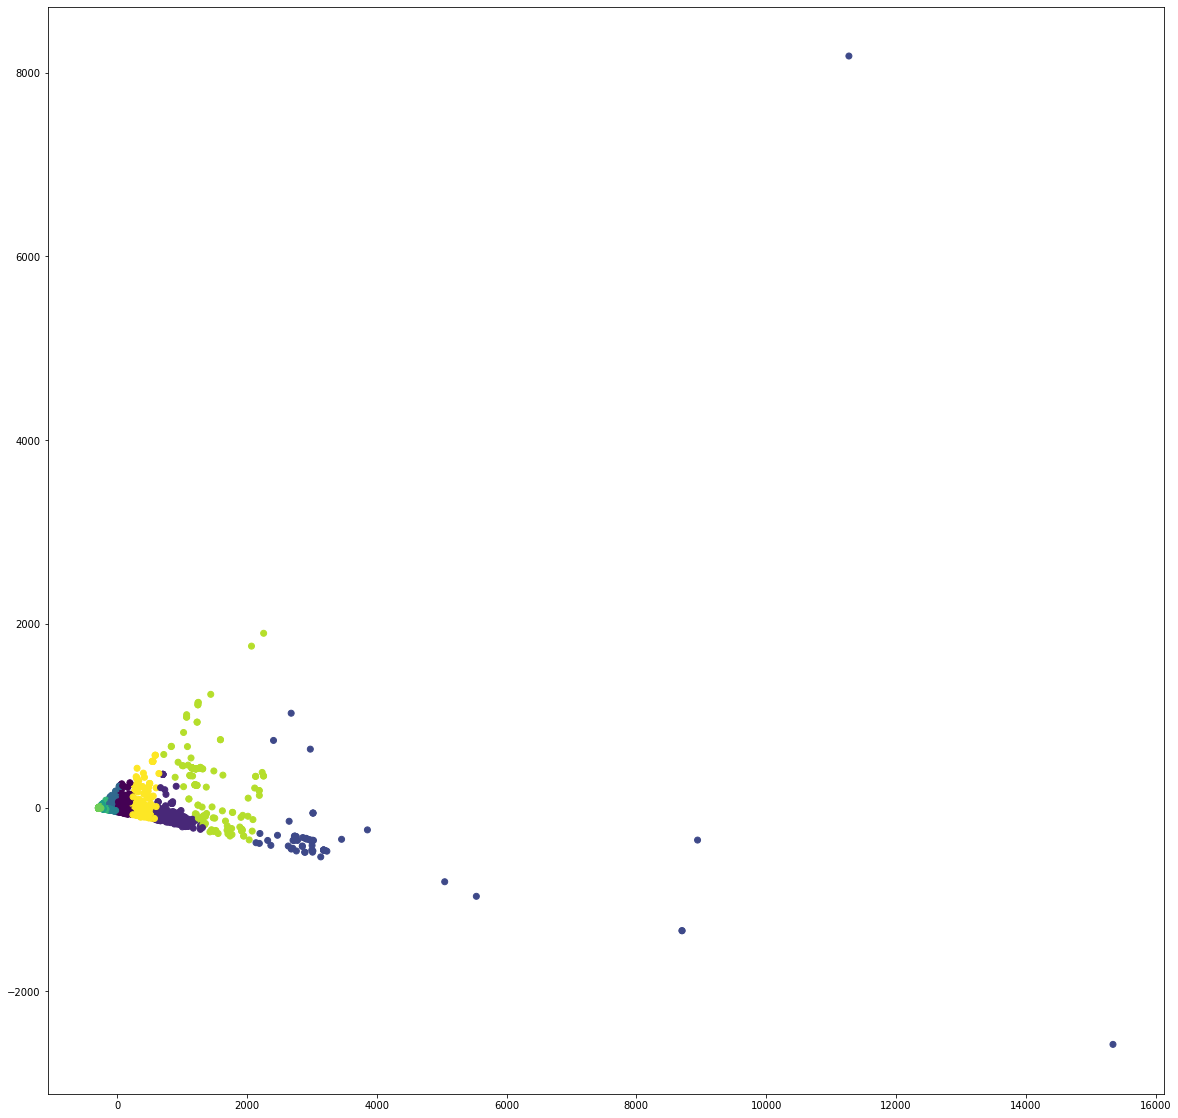

Pandas Distance = 327978.2208163152
Step = 3, Cost = 327978.22519918176


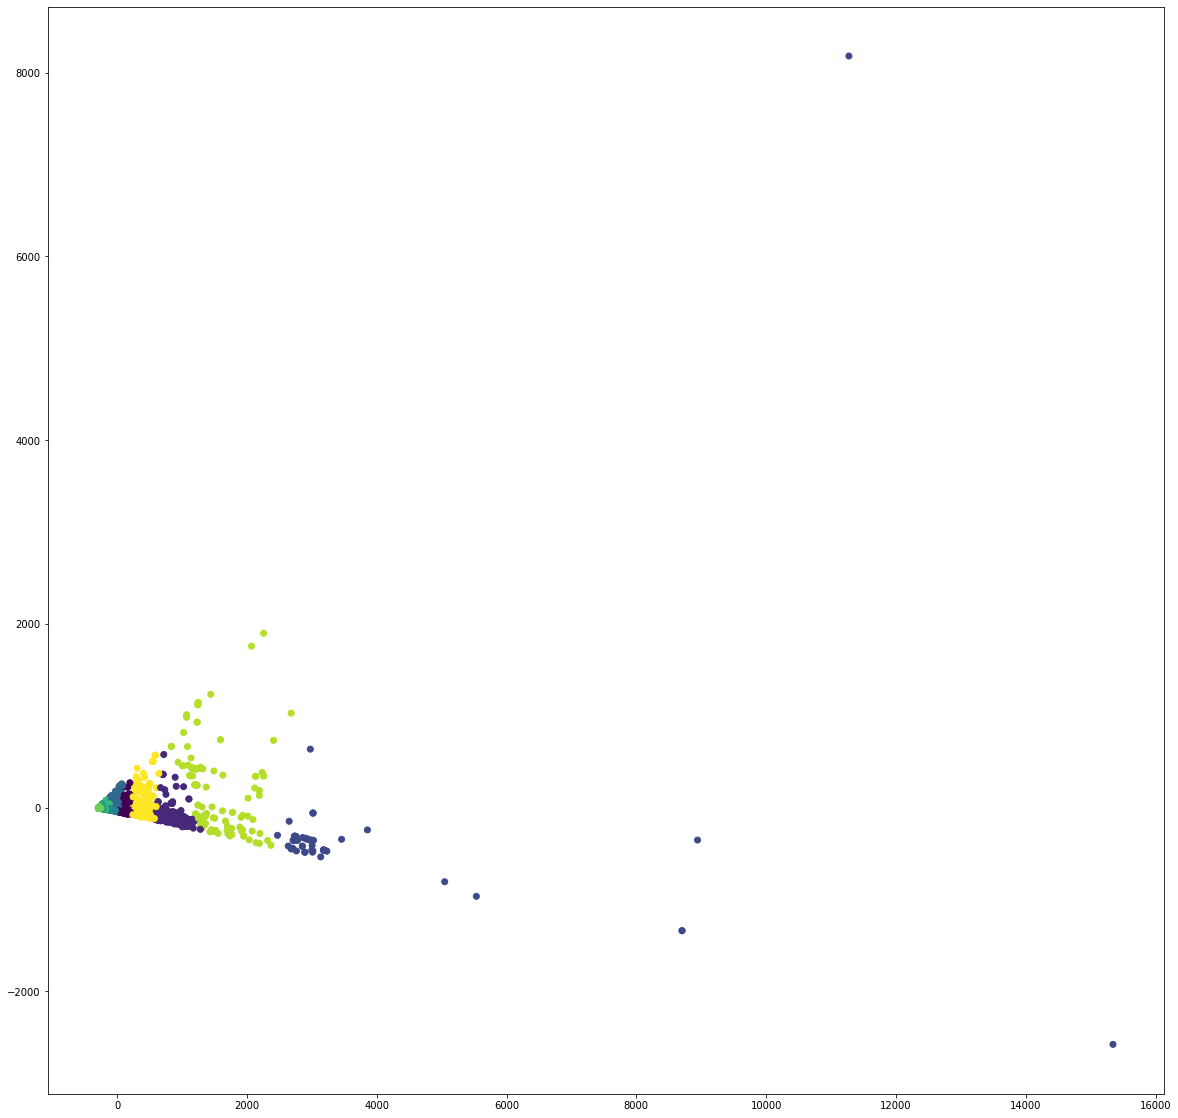

Pandas Distance = 333528.07760380296
Step = 4, Cost = 333528.0769713639


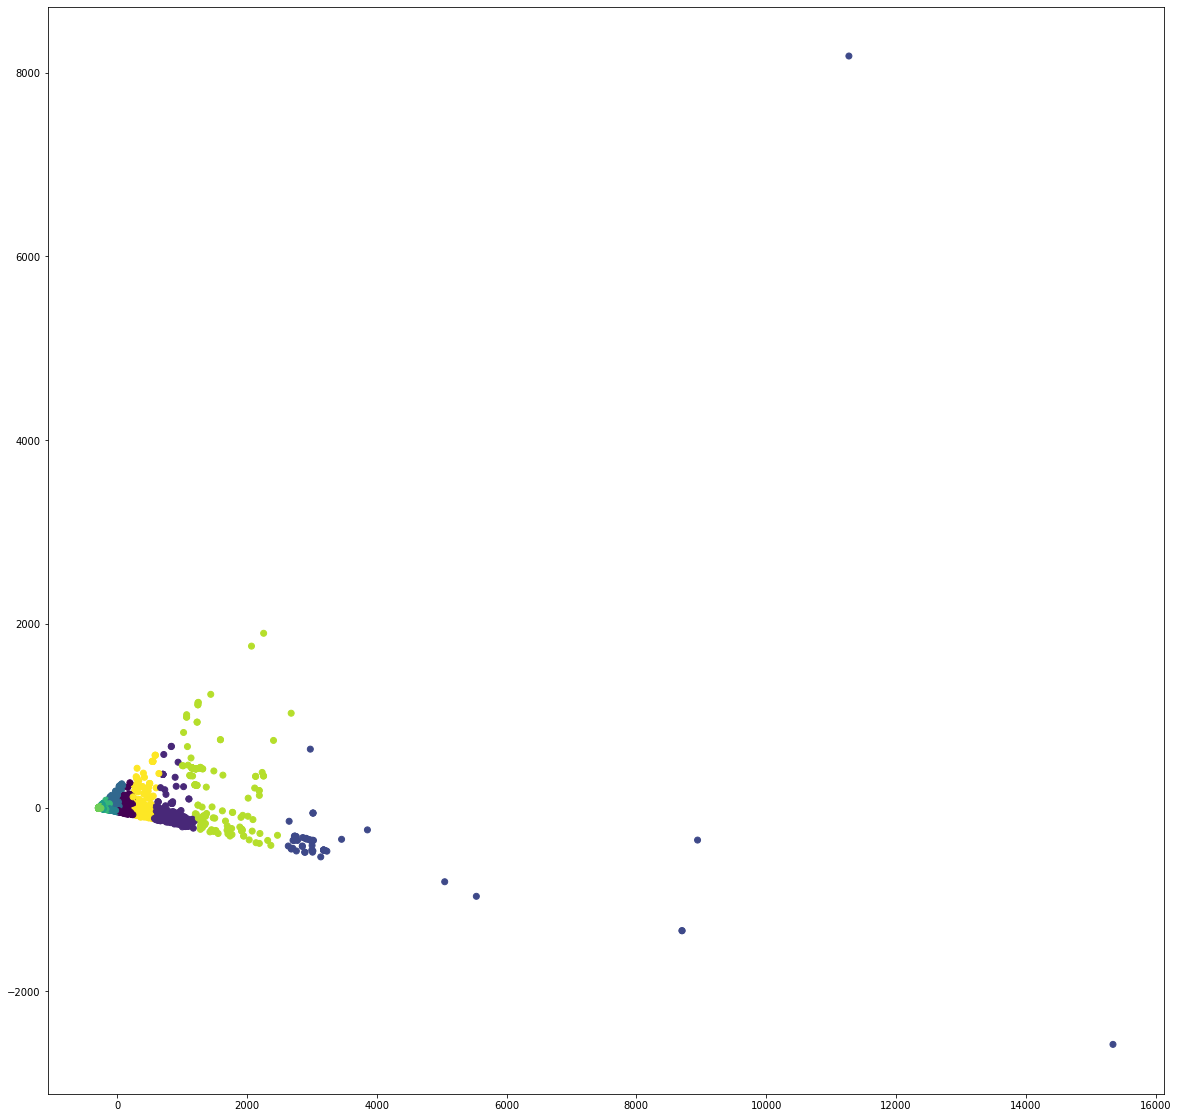

Pandas Distance = 334334.4194322742
Step = 5, Cost = 334334.41537335224


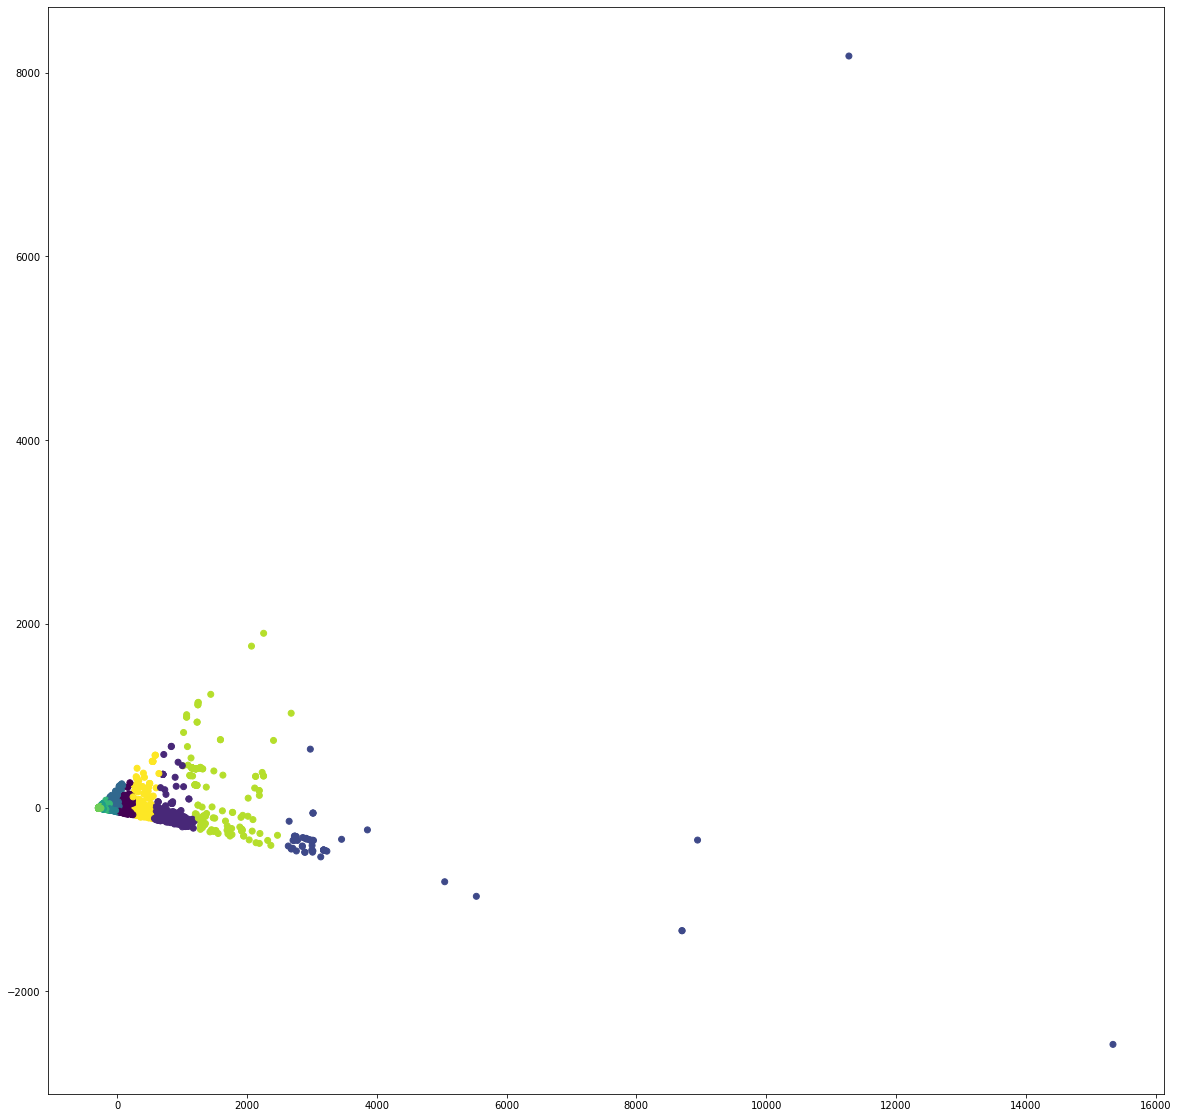

Pandas Distance = 334093.9076522841
Step = 6, Cost = 334093.90368501254


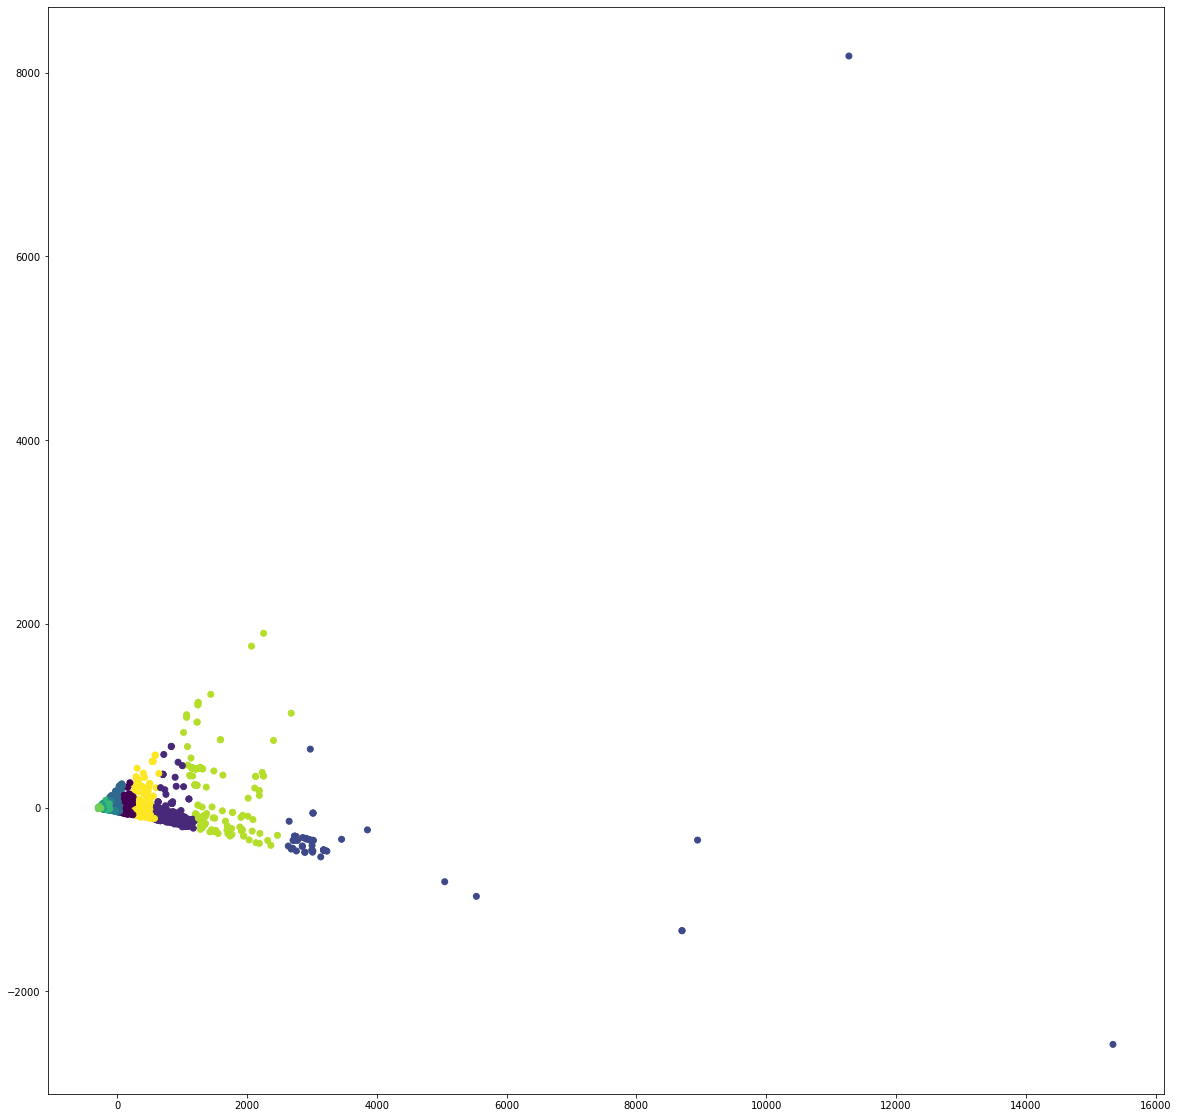

Pandas Distance = 333273.4354184942
Step = 7, Cost = 333273.4312510706


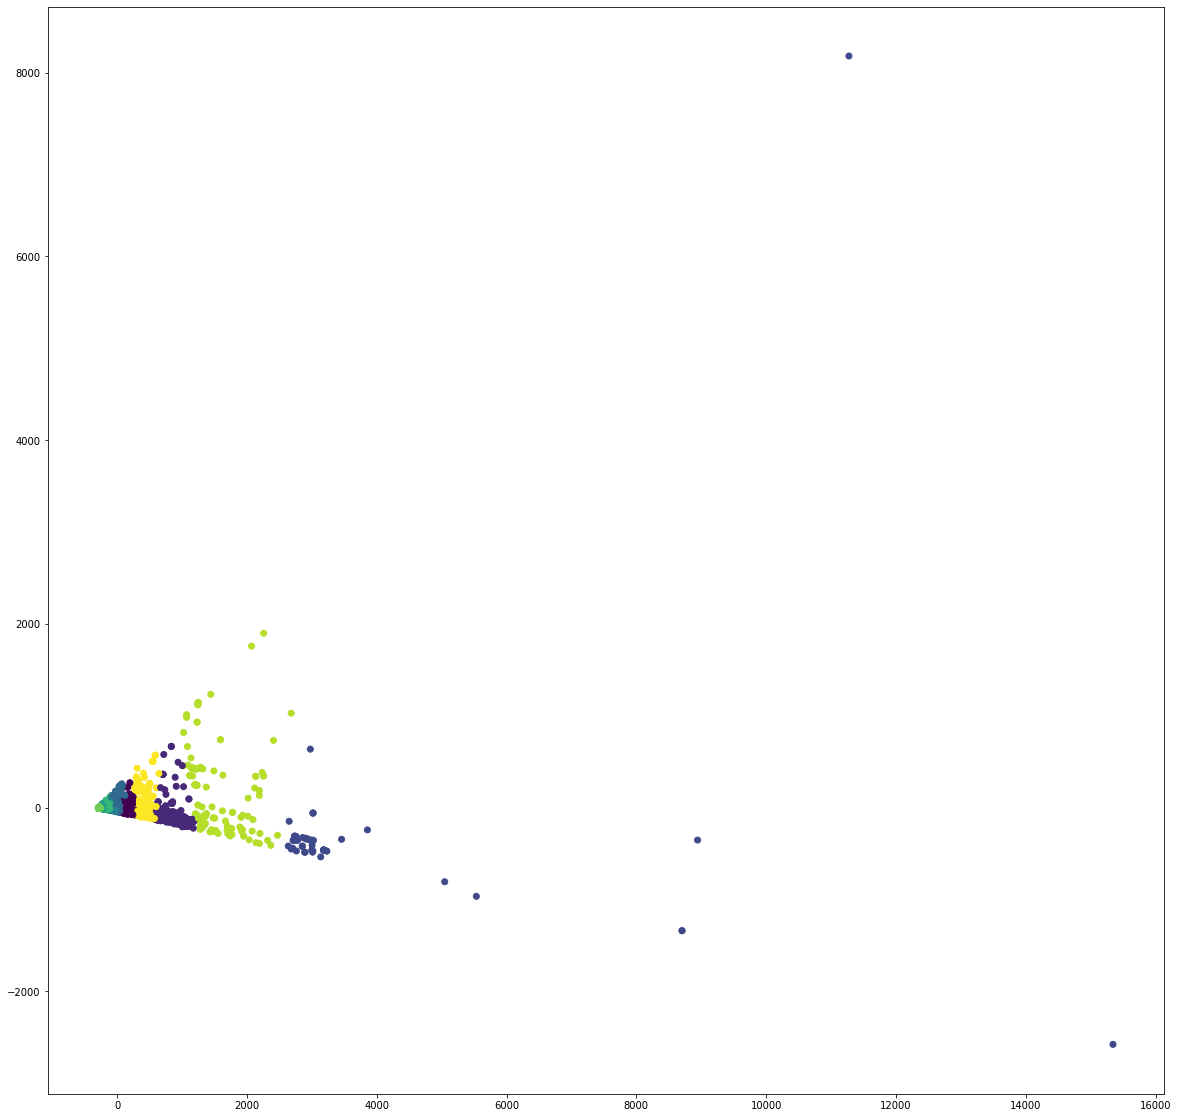

Pandas Distance = 331554.17954634543
Step = 8, Cost = 331554.1755801971


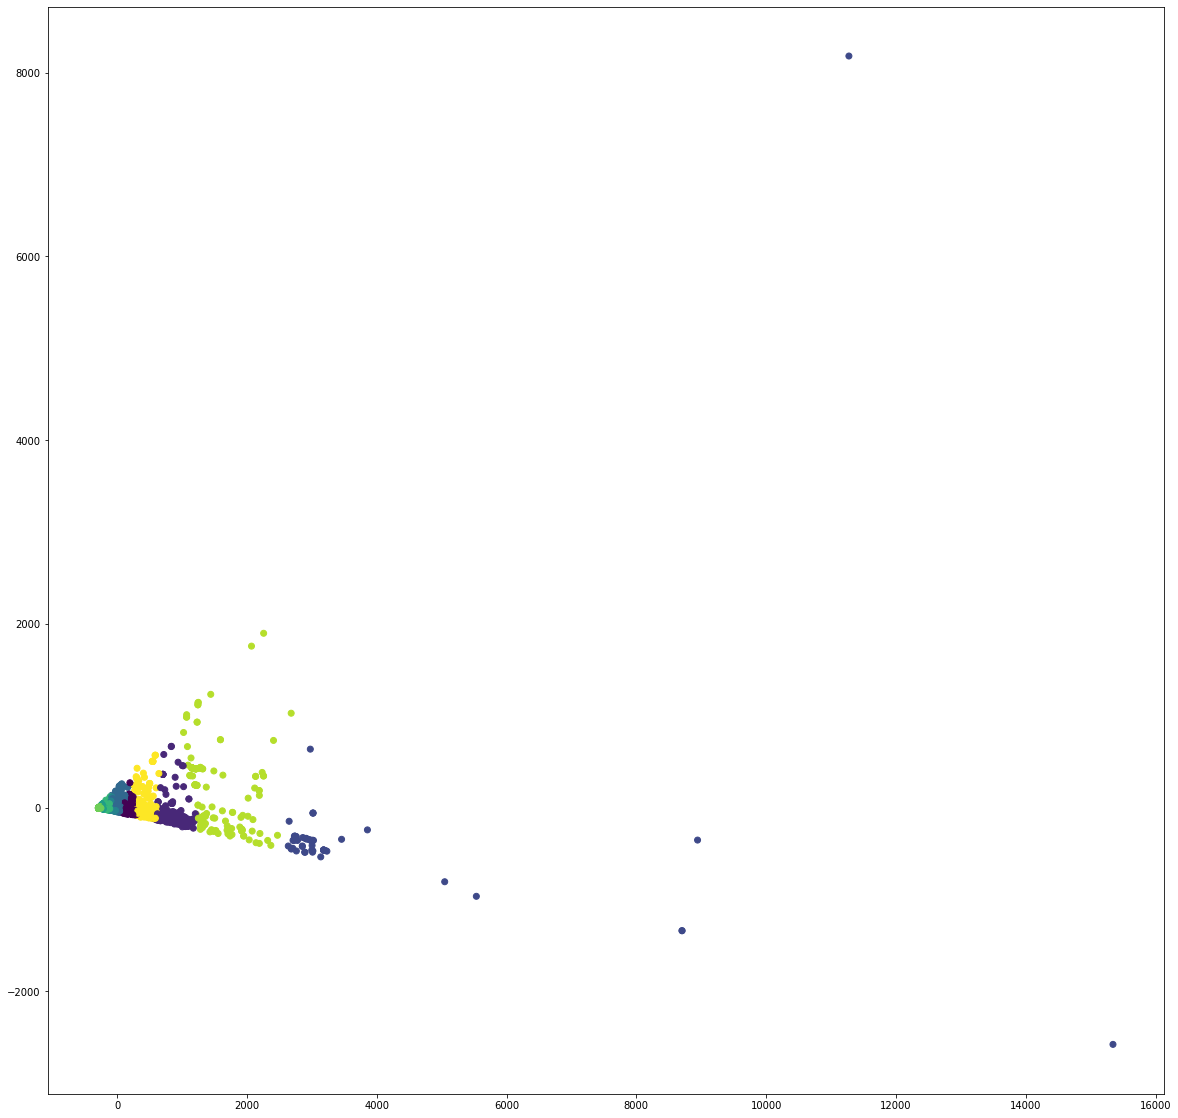

Pandas Distance = 329840.48152707546
Step = 9, Cost = 329840.47699853603


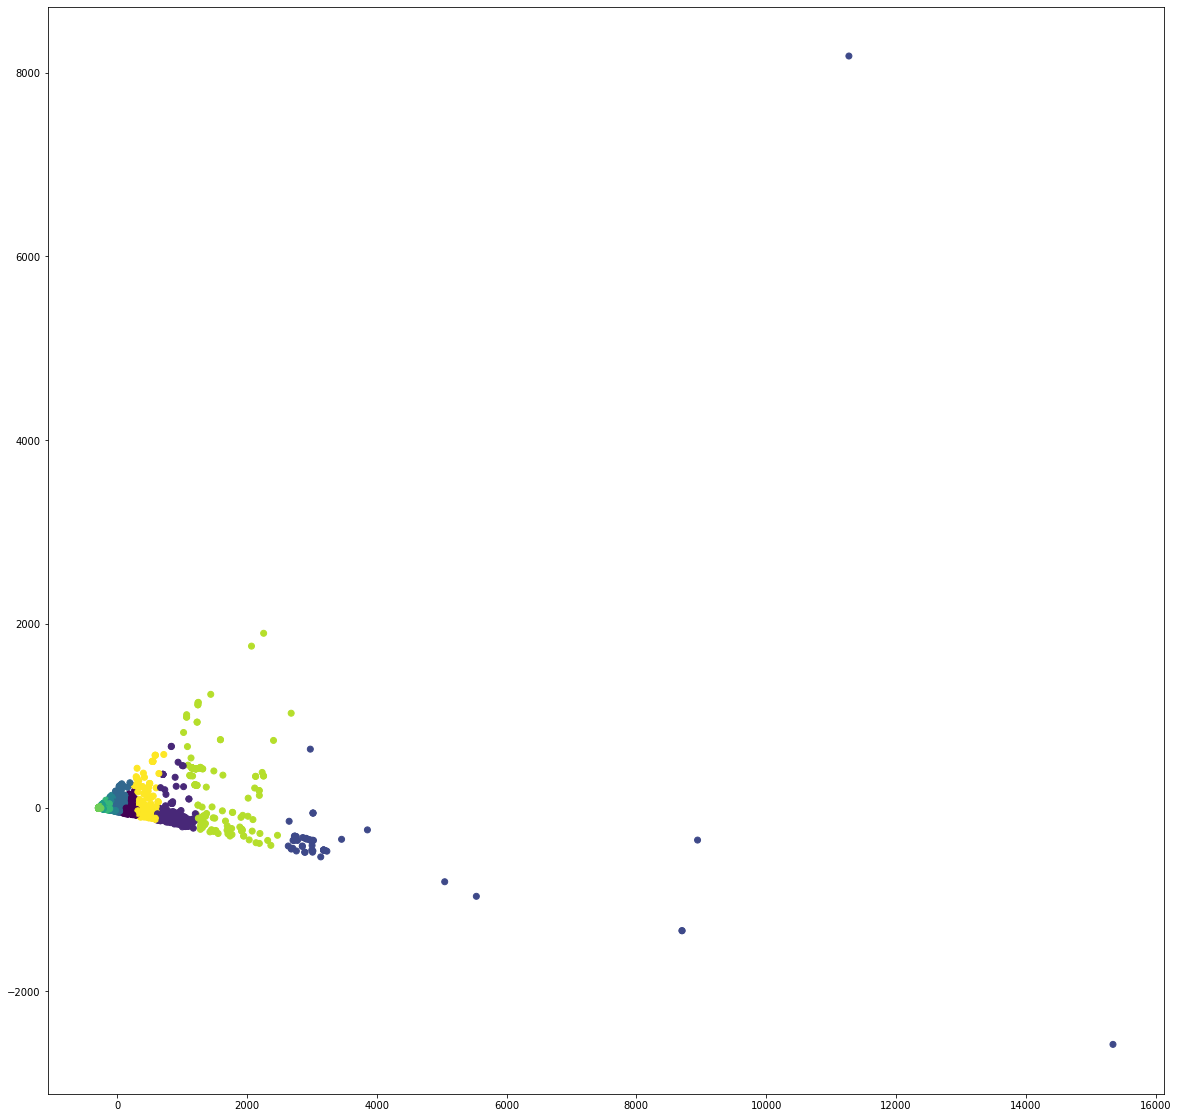

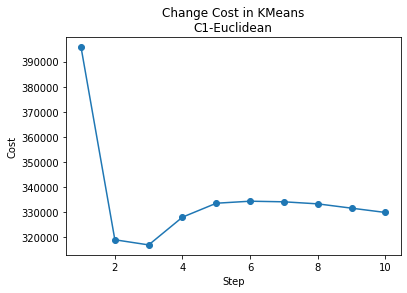

In [138]:
distance_metric_name = "Euclidean"
center, center_name = (c1_pandas, "C1")

print(f"Distance Metric = {distance_metric_name} | Center Name = {center_name}")

kmeans = SparkKMeans(dataset=dataset_pandas, center=center, description=f"{center_name}-{distance_metric_name}", distance_metric_name=distance_metric_name)

kmeans_output = kmeans.run(number_epochs=10)

kmeans.report()    

In [105]:
kmeans_output

,data-id,center-id
0,0,3
1,1,1
2,2,8
3,3,4
4,4,4
...,...,...
4596,4596,5
4597,4597,7
4598,4598,6
4599,4599,5


In [106]:
dataset_pandas

,data,data-id
0,"[0.0, 0.64, 0.64, 0.0, 0.32, 0.0, 0.0, 0.0, 0....",0
1,"[0.21, 0.28, 0.5, 0.0, 0.14, 0.28, 0.21, 0.07,...",1
2,"[0.06, 0.0, 0.71, 0.0, 1.23, 0.19, 0.19, 0.12,...",2
3,"[0.0, 0.0, 0.0, 0.0, 0.63, 0.0, 0.31, 0.63, 0....",3
4,"[0.0, 0.0, 0.0, 0.0, 0.63, 0.0, 0.31, 0.63, 0....",4
...,...,...
4596,"[0.31, 0.0, 0.62, 0.0, 0.0, 0.31, 0.0, 0.0, 0....",4596
4597,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4597
4598,"[0.3, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4598
4599,"[0.96, 0.0, 0.0, 0.0, 0.32, 0.0, 0.0, 0.0, 0.0...",4599


In [ ]:
pca = PCA(n_components=2)

In [109]:
from sklearn.decomposition import PCA

In [110]:
pca = PCA(n_components=2)

In [116]:
pca.fit(np.array([value for value in dataset_pandas["data"].values]))

PCA(n_components=2)

In [117]:
pca.explained_variance_ratio_

array([0.92702651, 0.07104294])

In [120]:
pca_output = pca.transform(np.array([value for value in dataset_pandas["data"].values]))

In [125]:
pca_output

array([[  -3.7867769 ,    9.4119307 ],
       [ 742.63220795,  -74.00122296],
       [2019.85415578,  102.07715318],
       ...,
       [-170.64388615,  -18.62981389],
       [-210.26932829,  -13.08453617],
       [-247.75502747,   -6.85136671]])

array([  9.4119307 , -74.00122296, 102.07715318, ..., -18.62981389,
       -13.08453617,  -6.85136671])

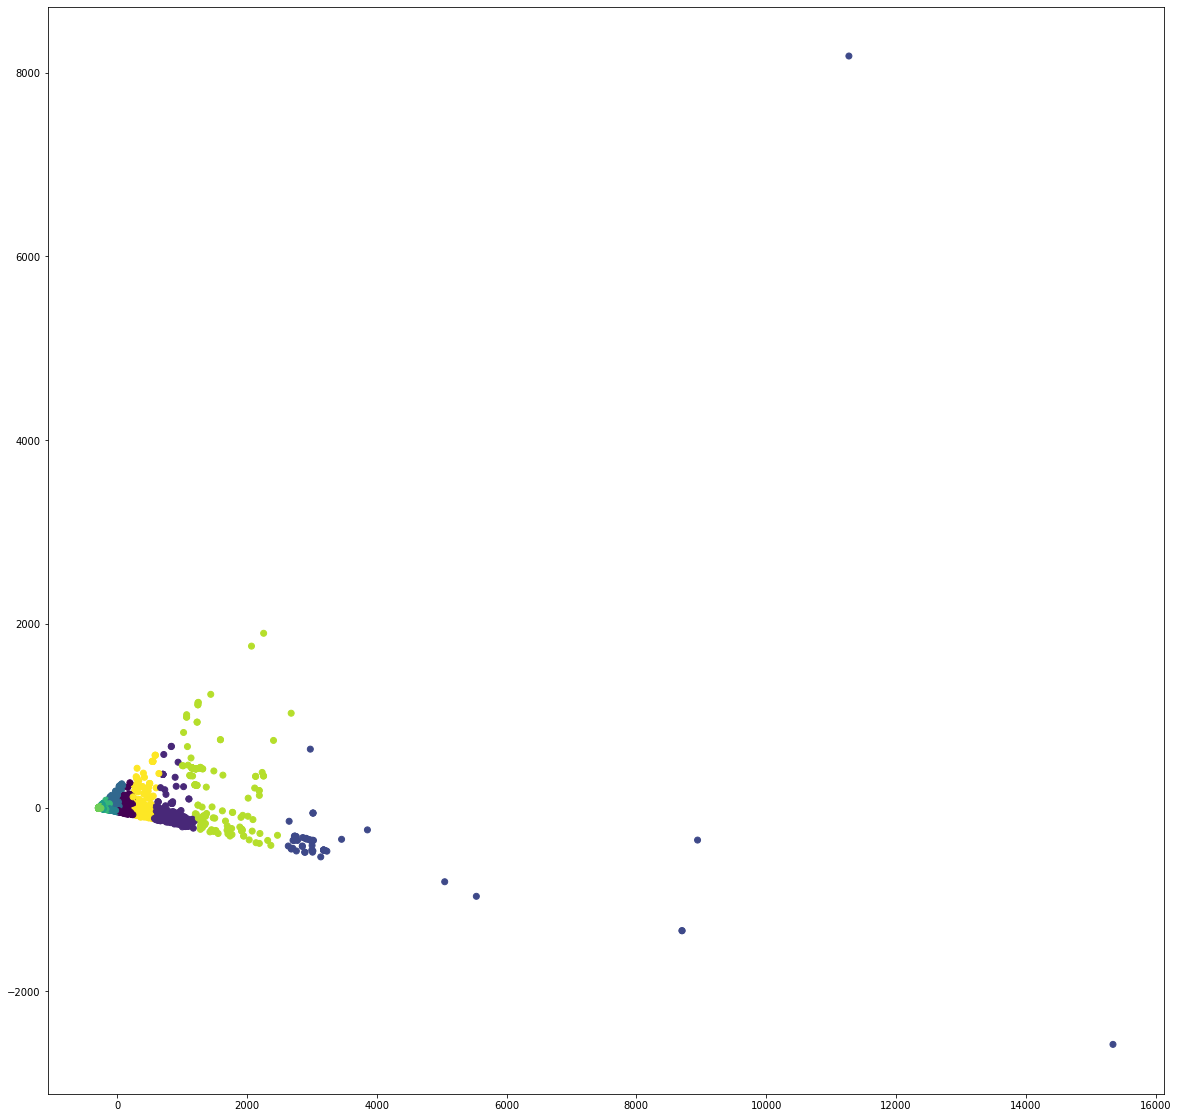

In [134]:
fig, ax = plt.subplots()

fig.set_size_inches(20,20)
ax.scatter(x=pca_output[:,0], y=pca_output[:,1], c=kmeans_output["center-id"].values)
plt.show()

In [139]:
from sklearn.cluster import KMeans

In [157]:
sklearn_kmeans = KMeans(n_clusters=10, init=np.array([value for value in c1_pandas["center"].values]), n_init=1, verbose=1)

In [158]:
sklearn_kmeans.fit(np.array([value for value in dataset_pandas["data"].values]))

Initialization complete
Iteration 0, inertia 623660345.3064116
Iteration 1, inertia 509862908.2975455
Iteration 2, inertia 485480681.8720086
Iteration 3, inertia 463997011.68501264
Iteration 4, inertia 460969266.5729967
Iteration 5, inertia 460537847.9827681
Iteration 6, inertia 460313099.6535445
Iteration 7, inertia 460003523.8894079
Iteration 8, inertia 459570539.3177354
Iteration 9, inertia 459021103.34229076
Iteration 10, inertia 458490656.19198096
Iteration 11, inertia 457944232.58797497
Iteration 12, inertia 457558005.1986774
Iteration 13, inertia 457290136.3523021
Iteration 14, inertia 457050555.059563
Iteration 15, inertia 456892235.6153561
Iteration 16, inertia 456703630.7370344
Iteration 17, inertia 456404203.0189751
Iteration 18, inertia 456177800.5419939
Iteration 19, inertia 455986871.02734715
Iteration 20, inertia 455729268.35514486
Iteration 21, inertia 455313045.0990431
Iteration 22, inertia 454742041.3496197
Iteration 23, inertia 454232362.726849
Iteration 24, inertia 

KMeans(init=array([[0.000e+00, 6.400e-01, 6.400e-01, 0.000e+00, 3.200e-01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.400e-01,
        0.000e+00, 0.000e+00, 0.000e+00, 3.200e-01, 0.000e+00, 1.290e+00,
        1.930e+00, 0.000e+00, 9.600e-01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00,...
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 6.000e-02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        4.000e-02, 3.000e-02, 0.000e+00, 2.440e-01, 8.100e-02, 0.000e+00,
        1.729e+00, 4.300e+01, 7.490e+02, 1.000e+00]]),
       n_clusters=10, n_init=1, verbose=1)

In [161]:
sklearn_kmeans.predict(np.array([value for value in dataset_pandas["data"].values]))

array([6, 3, 9, ..., 5, 7, 7], dtype=int32)

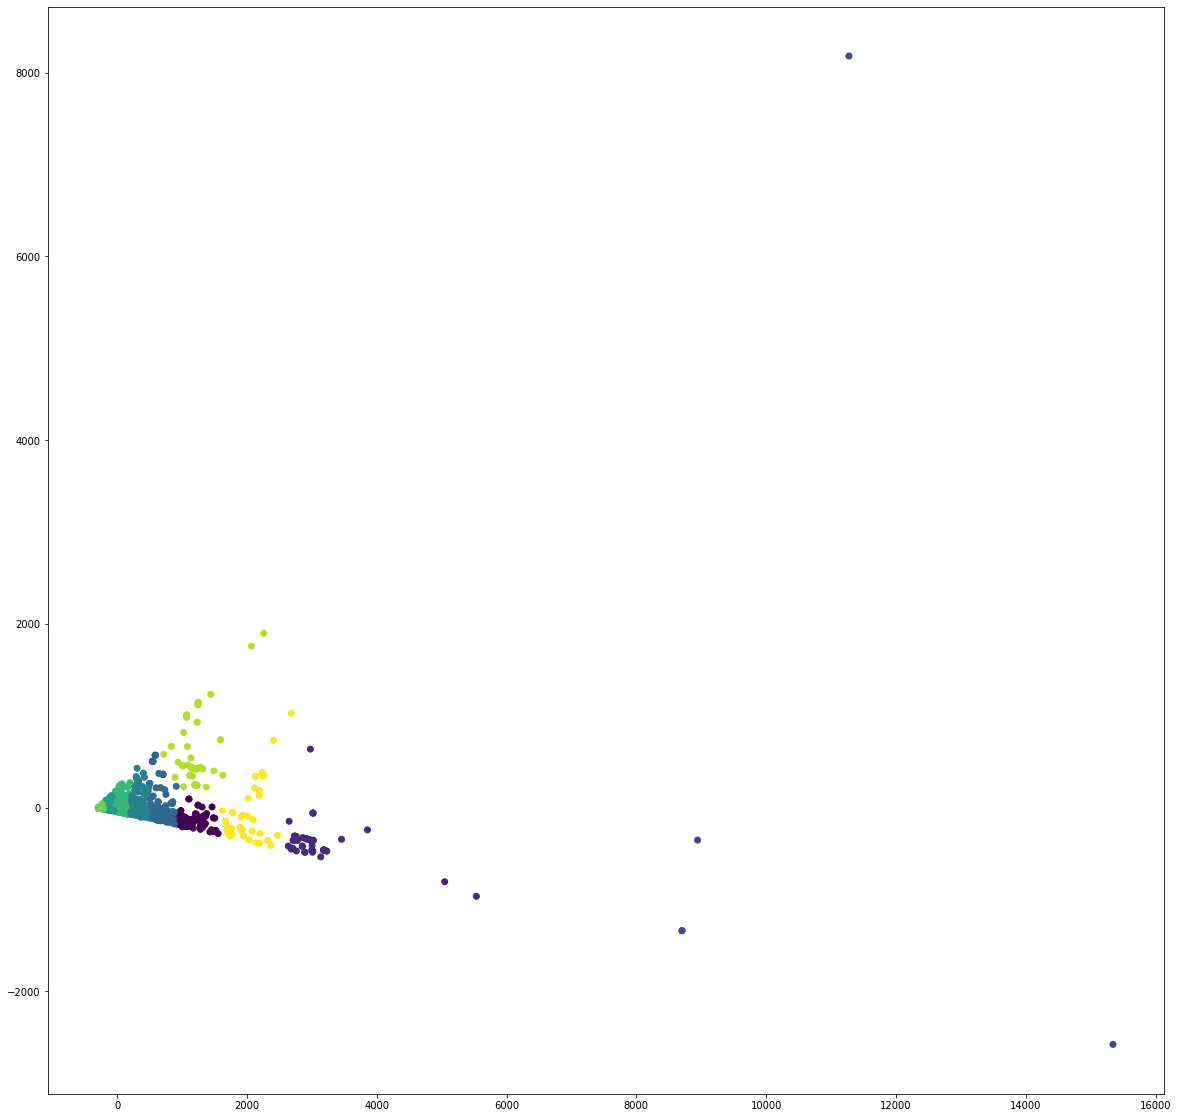

In [162]:
fig, ax = plt.subplots()

fig.set_size_inches(20,20)
ax.scatter(x=pca_output[:,0], y=pca_output[:,1], c=sklearn_kmeans.predict(np.array([value for value in dataset_pandas["data"].values])))
plt.show()